# Glacial diamictite ages and correlations
This notebook can be used to: 
- Compute the posterior age of individual glacial diamictite units
- Reproduce Fig. S40 (diamictite age ranges)
- Determine which correlation schemes are allowed, given these posterior ages and stratigraphic superposition constraints 
- Compute the age of each Paleoproterozoic glaciation under different correlation scenarios

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import stratmc
import warnings 

import scipy.stats as st

from matplotlib.patches import Rectangle
from tqdm.notebook import tqdm

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Avenir']
rcParams.update({
    "text.usetex": False
})

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

## Import data
Load diamictite summary data from `diamictite_compilation.csv` and Paleoproterozoic d13C/age constraint data. The posterior ages listed in `diamictite_compilation.csv` are computed below in [Link diamictite units to posterior age models](#Link-diamictite-units-to-posterior-age-models) 

In [2]:
data = pd.read_csv('data/diamictite_compilation.csv')

diamictites = np.unique(data['Diamictite'].values)
formations = np.unique(data['Formation'].values)
regions = np.unique(data['Region'].values)
basins = np.unique(data['Supergroup/Association'].values)


In [3]:
section_metadata = pd.read_csv('data/paleoproterozoic_section_metadata.csv')

sample_df, ages_df =  stratmc.data.load_data('data/paleoproterozoic_data', 
                                             'data/paleoproterozoic_ages', 
                                             combine_no_superposition = False)

sample_df_downsampled = stratmc.data.load_object('data/downsampling/downsampled_sample_df')


In [4]:
priority_1_sections = section_metadata[(section_metadata['Inversion priority level']==1) & (~section_metadata['Included in composite section?'])]['section']
priority_2_sections = section_metadata[(section_metadata['Inversion priority level']==2) & (~section_metadata['Included in composite section?'])]['section']
priority_3_sections = section_metadata[(section_metadata['Inversion priority level']==3) & (~section_metadata['Included in composite section?'])]['section']
priority_4_sections = section_metadata[(section_metadata['Inversion priority level']==4) & (~section_metadata['Included in composite section?'])]['section']

include_sections = np.concatenate([priority_1_sections, priority_2_sections])

## Load posterior age models
Load the Paleoproterozoic d13C inference results. Only required if re-computing posterior diamictite age ranges in [Link diamictite units to posterior age models](#Link-diamictite-units-to-posterior-age-models).

In [5]:
full_trace = stratmc.data.load_trace("traces/" + "paleoproterozoic_d13C_trace")

## Link diamictite units to posterior age models
Code to compute the posterior age of each diamictite unit. Running these cells is not required; computed ages are included in `diamictite_compilation.csv`.

In [6]:
# for co-eval sections, manually link to appropriate stratigraphic horizons in d13C sections (none are co-eval with entire section) 
height_range = {}

height_range['Meteorite Bore Member'] = {'Turee Creek Composite': (259, 757)} # note - should just use depositional age for this one 
height_range['Kazput'] = {'Turee Creek Composite': (1180, 1503)}

height_range['Lower Duitschland'] = {'Tongwane-Duitschland composite': (240, 244)} # younger than Tongwane, older than Duitschland

height_range['Headquarters'] = {'Snowy Pass Supergroup Composite': (65, 115)} # younger than Vagner carbonates, older than Nash Fork

In [7]:
# create columns to store posterior diamictite ages (median and 95% envelopes)
data['Max. posterior age (median)'] = np.nan
data['Max. posterior age (97.5%)'] = np.nan
data['Min. posterior age (median)'] = np.nan
data['Min. posterior age (2.5%)'] = np.nan

# iterate over diamictite units
for i in tqdm(range(data.shape[0])): 
            
    # compile list of sections that must be older than the current diamictite
    if str(data.loc[i]['Older sections']) != 'nan': 
        older_sections = list([data.loc[i]['Older sections']])
        older_sections = np.array([x.strip() for x in older_sections[0].split(',')])

        older_sections = [section for section in older_sections if section in include_sections]

    else: 
        older_sections = [] 

    # compile list of sections that must be younger than the current diamictite
    if str(data.loc[i]['Younger sections']) != 'nan': 
        younger_sections = list([data.loc[i]['Younger sections']])
        younger_sections = np.array([x.strip() for x in younger_sections[0].split(',')])
        younger_sections = [section for section in younger_sections if section in include_sections]

    else: 
        younger_sections = [] 

    # if age of diamictute is constrained by older sections, compute posterior maximum age
    if len(older_sections) > 0: 
        # iterate over older sections
        for k, section in enumerate(older_sections): 
            sec_ages = az.extract(full_trace.posterior)[section + '_ages'].values

            # grab the youngest sample from each underlying section (which provide a maximum age constraint for the diamictite)
            if k == 0: 
                youngest_sample_ages = sec_ages[-1, :]

            else: 
                youngest_sample_ages = np.vstack([youngest_sample_ages,  sec_ages[-1, :]])

        if len(youngest_sample_ages.shape) == 1: 
            youngest_sample_ages = youngest_sample_ages.reshape((1, youngest_sample_ages.shape[0]))

        # tightest maximum age = youngest underlying sample (for each posterior draw) 
        youngest_sample_ages = np.min(youngest_sample_ages, axis = 0)

        # save median inferred maximum age (i.e., median of youngest underlying sample ages)
        data['Max. posterior age (median)'].iloc[i] = np.percentile(youngest_sample_ages, 50)
        
        # save 97.5 percentile maximum age (i.e., 97.5 percentile of youngest underlying sample ages)
        data['Max. posterior age (97.5%)'].iloc[i] = np.percentile(youngest_sample_ages, 97.5)

    # if age of diamictite is constrained by younger sections, compute posterior minimum age 
    if len(younger_sections) > 0: 
        # iterate over younger sections
        for k, section in enumerate(younger_sections): 
            sec_ages = az.extract(full_trace.posterior)[section + '_ages'].values

            # grab the oldest sample from each overlying section (which provides a minimum age constraint for the diamictite) 
            if k == 0: 
                oldest_sample_ages = sec_ages[0, :]

            else: 
                oldest_sample_ages = np.vstack([oldest_sample_ages,  sec_ages[0, :]])


        if len(oldest_sample_ages.shape) == 1: 
            oldest_sample_ages = oldest_sample_ages.reshape((1, oldest_sample_ages.shape[0]))

        # tightest minimum age = oldest overlying sample (for each posterior draw) 
        oldest_sample_ages = np.max(oldest_sample_ages, axis = 0)

        # save median inferred minimum age (i.e., median of oldest overlying sample ages)
        data['Min. posterior age (median)'].iloc[i] = np.percentile(oldest_sample_ages, 50)
        
        # save 2.5 percentile minimum age (i.e., 2.5 percetile of oldest overlying sample ages)
        data['Min. posterior age (2.5%)'].iloc[i] = np.percentile(oldest_sample_ages, 2.5)
            
# compute age ranges for co-eval sections that are linked to specific stratigraphic intervals 
for key in tqdm(list(height_range.keys())):
    idx = np.where(data['Diamictite'] == key)[0]
        
    # note - if more than one linked section, would need to loop over them; not necessary given the current constraints
    section = list(height_range[key].keys())[0]
    
    sec_ages = az.extract(full_trace.posterior)[section + '_ages'].values
    
    section_df = sample_df_downsampled[sample_df_downsampled['section'] == section]
    
    # grab ages of bounding samples, based on linked height ranges
    lower_height = height_range[key][section][0]
    upper_height = height_range[key][section][1]
    
    underlying_idx = section_df['height'] <= lower_height
    overlying_idx = section_df['height'] >= upper_height
    
    under_ages = sec_ages[underlying_idx, :]
    over_ages = sec_ages[overlying_idx, :]
    
    # grab youngest underlying sample age, which provides a maximum age constraint for the diamictite
    youngest_underlying_ages = under_ages[-1, :]
    
    # grab oldest overlying sample age, which provides a minimum age constraint for the diamictite
    oldest_overlying_ages = over_ages[0, :]
    
    # save median and 95% intervals for the diamictite, based on ages of the youngest underlying and oldest overlying samples
    data['Max. posterior age (median)'].iloc[idx] = np.percentile(youngest_underlying_ages, 50)
    data['Max. posterior age (97.5%)'].iloc[idx] = np.percentile(youngest_underlying_ages, 97.5)
    
    data['Min. posterior age (median)'].iloc[idx] = np.percentile(oldest_overlying_ages, 50)
    data['Min. posterior age (2.5%)'].iloc[idx] = np.percentile(oldest_overlying_ages, 2.5)
    
# data.to_csv('data/diamictite_compilation_with_posterior_ages.csv', index = False)

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

## Plot diamictite age ranges (Fig. S40)


In [5]:
# basin order for plotting 
basins = ['Huronian Supergroup', 
          'Mount Bruce Supergroup', 
          'Transvaal Supergroup - Transvaal Basin', 
          'Transvaal Supergroup - Griqualand West', 
          'Imandra/Varzuga Greenstone Belt', 
          'Snowy Pass Supergroup',
          'Marquette Range Supergroup (Marquette Range)', 
          'Marquette Range Supergroup (Menominee)']

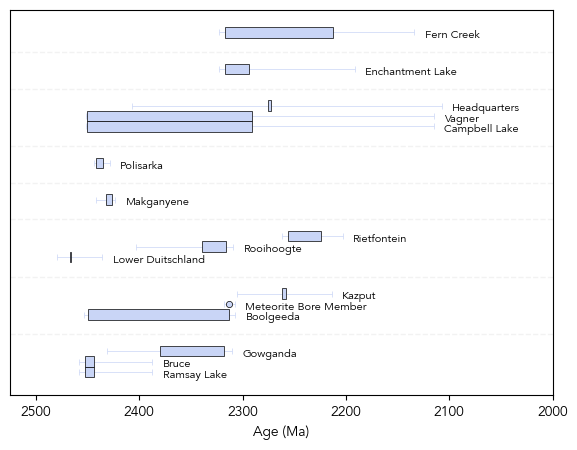

In [6]:
fig = plt.figure(figsize = (7, 5))
ax = fig.gca() 

## plot the posterior age range for each basin

base_value = 0
plotted_depositional = False 

# iterate over basins
for i, basin in enumerate(basins): 
    
    if i > 0:
        ax.axhline(base_value - 0.75, color = (0.95, 0.95, 0.95), linestyle = 'dashed', lw = 1)
        
    # filter data for current basin
    basin_df = data[data['Supergroup/Association'] == basin]
    
    # grab stratigraphic order of diamictite units within the current basin 
    basin_levels = basin_df['Stratigraphic order (within basin)'].values
    
    # iterate over diamictite units within the current basin 
    for j in range(basin_df.shape[0]): 
        formation_df = basin_df.iloc[j]
        
        level = formation_df['Stratigraphic order (within basin)']
        value = base_value + 0.4 * (level - 1) 
        
        # check if diamictite has a depositional age (i.e., the diamictite unit has been dated directly)
        dep_age = formation_df['Depositional age']
        dep_age_std = formation_df['Depositional age std']

        # check whether geochronological age constraints or posterior age models provide a tighter constraint on the minimum age of the diamictite unit, and grab tightest constraint
        if formation_df['Min. posterior age (median)'] > formation_df['Min age']:
            min_age = formation_df['Min. posterior age (median)'] 
            min_age_std = (formation_df['Min. posterior age (median)'] - formation_df['Min. posterior age (2.5%)'])/2 # equating 95% posterior interval to 2-sigma uncertainty of geochronological constraint

        else:
            min_age = formation_df['Min age']
            min_age_std = formation_df['Min age std']

        # check whether geochronological age constraints or posterior age models provide a tighter constraint on the maximum age of the diamictite unit, and grab tightest constraint
        if formation_df['Max. posterior age (median)'] < formation_df['Max age']:
            max_age = formation_df['Max. posterior age (median)']
            max_age_std = (formation_df['Max. posterior age (97.5%)'] - formation_df['Max. posterior age (median)'])/2 # equating 95% posterior interval to 2-sigma uncertainty of geochronological constraint

        else: 
            max_age = formation_df['Max age']
            max_age_std = formation_df['Max age std']

        color ='#C9D5F6'                 

        label = '_nolabel'

        # if the diamictite has a depositional age constraint, use that for plotting (should provide the tightest constraint) 
        if ~np.isnan(dep_age):
            if not plotted_depositional: 
                dep_label = 'Depositional'
                plotted_depositional = True

            else: 
                dep_label = '_nolabel'

            (_, caps, _) = ax.errorbar(dep_age, 
                           value, 
                           xerr = 2 * dep_age_std, 
                           alpha = 1, 
                           color = color, 
                           lw = 0.5, 
                           zorder = 8,
                           capsize = 2,
                             elinewidth = 0.5, 
                           clip_on = False)

            for cap in caps:
                cap.set_markeredgewidth(0.5)


            ax.scatter(dep_age, 
                         value, 
                     color = color, 
                       marker = 'o',
                    edgecolor = 'k',
                       alpha = 1, #0.6,
                     lw = 0.5,  
                     zorder = 10, 
                    clip_on = True,
                    s = 20, 
                      label = dep_label)
            
            ax.text(dep_age - 2 * dep_age_std - 10, value - 0.2, formation_df['Diamictite'], color = 'k', fontsize = 8)

        # if diamictite does not have a depositional age constraint, use the minimum/maximum age identified above (from geochron or posterior age models)
        else:
            mean_age = (max_age + min_age)/2
            right_error = (max_age - mean_age) + 2 * max_age_std
            left_error = (mean_age - min_age) + 2 * min_age_std
            xerr = np.array([left_error, right_error]).reshape(2, 1)

            (_, caps, _)  = ax.errorbar(mean_age, 
                                        value, 
                                        xerr = xerr,
                                        color = color, 
                                        alpha = 1,
                                        lw = 0.5, 
                                        capsize = 2,
                                        elinewidth = 0.5, 
                                        zorder = 3, 
                                        clip_on = False)

            
            ax.text(mean_age - left_error - 10, value - 0.2, formation_df['Diamictite'], color = 'k', fontsize = 8)

            for cap in caps:
                cap.set_markeredgewidth(0.5)

            age_rect = Rectangle((min_age, value - 0.2), # lower left cornner
                                max_age - min_age,  # width
                                0.4,  # height
                                facecolor = color, 
                                alpha = 1, #0.6,
                                edgecolor = 'k', 
                                lw = 0.5,
                                zorder = 4,
                                clip_on = False) 

            ax.add_patch(age_rect)
            

    base_value += len(np.unique(basin_levels)) * 0.4 + 1
        
        
ax.invert_xaxis()
ax.set_yticks([])
ax.set_xlim([2525, 2000])
ax.set_xlabel('Age (Ma)')

file = 'FigS40'
fig.savefig(str("figures/"+ file +".pdf"), format="pdf", dpi = 500, facecolor='white', transparent=False, bbox_inches='tight', pad_inches=0.2)


## Evaluate diamictite correlations
Using the Huronian diamictite as a scaffold, check which diamictite units may be co-eval/associated with the same glacial event, given the geochronological age constraints and superposition constraints. Assumes a total of four Paleoproterozoic glaciations (the minimum required to explain the observations, assuming glaciations are global). 

In [7]:
# diamictite units in the Huronian Supergroup. Note that only three diamictites are preserved in this basin, but a fourth ('post-Gowganda') is required by the age constraints and stratigraphy elsewhere in the world
huronian_diamictites = ['Ramsay Lake', 'Bruce', 'Gowganda', 'post-Gowganda']

# compute the age range of each Huronian diamictute unit (95% envelopes)
huronian_max_ages = {} 
huronian_min_ages = {} 
huronian_max_ages_95 = {} 
huronian_min_ages_95 = {} 

huronian_max_ages['Ramsay Lake'] = data[data['Diamictite'] == 'Ramsay Lake']['Max age'].values[0]
huronian_min_ages['Ramsay Lake'] = data[data['Diamictite'] == 'Ramsay Lake']['Min. posterior age (median)'].values[0]
huronian_max_ages_95['Ramsay Lake'] = data[data['Diamictite'] == 'Ramsay Lake']['Max age'].values[0] + 2 * data[data['Diamictite'] == 'Ramsay Lake']['Max age std'].values[0]
huronian_min_ages_95['Ramsay Lake'] = data[data['Diamictite'] == 'Ramsay Lake']['Min. posterior age (2.5%)'].values[0]

huronian_max_ages['Bruce'] = data[data['Diamictite'] == 'Bruce']['Max age'].values[0]
huronian_min_ages['Bruce'] = data[data['Diamictite'] == 'Bruce']['Min. posterior age (median)'].values[0]
huronian_max_ages_95['Bruce'] = data[data['Diamictite'] == 'Bruce']['Max age'].values[0] + 2 * data[data['Diamictite'] == 'Ramsay Lake']['Max age std'].values[0]
huronian_min_ages_95['Bruce'] = data[data['Diamictite'] == 'Bruce']['Min. posterior age (2.5%)'].values[0]

huronian_max_ages['Gowganda'] = data[data['Diamictite'] == 'Gowganda']['Max. posterior age (median)'].values[0]
huronian_min_ages['Gowganda'] = data[data['Diamictite'] == 'Gowganda']['Min age'].values[0]
huronian_max_ages_95['Gowganda'] = data[data['Diamictite'] == 'Gowganda']['Max. posterior age (97.5%)'].values[0]
huronian_min_ages_95['Gowganda'] = data[data['Diamictite'] == 'Gowganda']['Min age'].values[0] - 2 * data[data['Diamictite'] == 'Gowganda']['Min age std'].values[0] 

huronian_max_ages['post-Gowganda'] = huronian_min_ages['Gowganda'] # set equal to median Gowganda min age 
huronian_min_ages['post-Gowganda'] = 0 # no minimum age since event not perserved in this basin
huronian_max_ages_95['post-Gowganda'] = huronian_min_ages_95['Gowganda'] # set equal to 95% Gowganda min age 
huronian_min_ages_95['post-Gowganda'] = 0 # no minimum age since event not preserved in this basin 

# compute the age range of each diamictite
diamictite_max_ages_95 = {} 
diamictite_min_ages_95 = {} 
for diamictite in diamictites: 
    formation_df = data[data['Diamictite'] == diamictite]

    # grab min/max age for diamictite
    dep_age = formation_df['Depositional age'].values[0]
    dep_age_std = formation_df['Depositional age std'].values[0]

    if ~(np.isnan(dep_age)): 
        diamictite_min_ages_95[diamictite] = dep_age - 2 * dep_age_std

    elif formation_df['Min. posterior age (median)'].values[0] > formation_df['Min age'].values[0]:
        diamictite_min_ages_95[diamictite] = formation_df['Min. posterior age (2.5%)'].values[0]

    else:
        diamictite_min_ages_95[diamictite] = formation_df['Min age'].values[0] - 2 * formation_df['Min age std'].values[0]

    if ~np.isnan(dep_age): 
        diamictite_max_ages_95[diamictite] = dep_age + 2 * dep_age_std

    elif formation_df['Max. posterior age (median)'].values[0] < formation_df['Max age'].values[0]:
        diamictite_max_ages_95[diamictite] = formation_df['Max. posterior age (97.5%)'].values[0]

    else: 
        diamictite_max_ages_95[diamictite] = formation_df['Max age'].values[0] + 2 * formation_df['Max age std'].values[0]
    
    
overlap_results_95 = {} 
# check whether correlation between each non-Huronian diamictite and each Huronian diamictite are allowed (i.e., whether the 95% age ranges overlap)
for diamictite in diamictites: 
    if diamictite not in huronian_diamictites:
        overlap_results_95[diamictite] = {} 
        
        # check whether age range overlaps w/ each Huronian diamictite
        for huronian_diamictite in huronian_diamictites: 
            interval = pd.Interval(diamictite_min_ages_95[diamictite], diamictite_max_ages_95[diamictite]) 
            huronian_interval = pd.Interval(huronian_min_ages_95[huronian_diamictite], huronian_max_ages_95[huronian_diamictite]) 

            # checking whether the age ranges overlap (true/false output)
            overlap_results_95[diamictite][huronian_diamictite] = interval.overlaps(huronian_interval)


### Table S3 (diamictite correlations)

In [8]:
correlation_df_95 = pd.DataFrame(columns = ['Ramsay Lake', 'Bruce', 'Gowganda', 'post-Gowganda'])

ordered_diamictites = ['Boolgeeda', # Australia
                       'Meteorite Bore Member', 
                       'Kazput',
                       'Lower Duitschland', # Transvaal (Transvaal)
                       'Rooihoogte',
                       'Rietfontein',
                       'Makganyene', # Transvaal (Griqualand West)
                       'Polisarka', # Imandra-Varzuga
                       'Campbell Lake', # Snowy Pass
                       'Vagner',
                       'Headquarters', 
                       'Enchantment Lake', # Marquette Range Supergroup (Marquette) 
                       'Fern Creek' # Marquette Range Supergroup (Menominee)
                      ]
 

for diamictite in ordered_diamictites: 
    if diamictite not in huronian_diamictites: 
        
        correlation_df_95.loc[diamictite] = overlap_results_95[diamictite]

    
for col in list(correlation_df_95): 
    correlation_df_95[col] = correlation_df_95[col].astype(float)

In [9]:
## address cases where correlation is not allowed due to stratigraphic constraints (e.g., the second diamictite within a given basin cannot be associated 
# with the oldest glaciation), even though the correlation is allowed by the geochronology

# there are two younger diamictites in Australia (Pilbara), which means the Boolgeeda must be associated with glacial 1 or 2 (assuming four total glaciations)
correlation_df_95.loc['Boolgeeda', 'Gowganda']= 0.5
correlation_df_95.loc['Boolgeeda', 'post-Gowganda']= 0.5

# there is one younger diamictite in Australia (Pilbara), which means the MBM cannot be associated with the fourth (youngest) glaciation
correlation_df_95.loc['Meteorite Bore Member', 'post-Gowganda']= 0.5

# in the Transvaal Basin, the overlying Rietfontein diamictite must be associated with the fourth glacial (due to geochron and correlation with Huronian)
correlation_df_95.loc['Rooihoogte', 'post-Gowganda']= 0.5
# there is also one underlying diamictite, which means the Rooihoogte cannot be associated with the first glacial
correlation_df_95.loc['Rooihoogte', 'Ramsay Lake']= 0.5

# there are two overlying diamictites in the Snowy Pass Supergroup, which means the Campbell Lake must be associated with glacial 1 or 2 (but not 3 or 4)
correlation_df_95.loc['Campbell Lake', 'Gowganda']= 0.5
correlation_df_95.loc['Campbell Lake', 'post-Gowganda']= 0.5
# there is one underlying and one overlying diamictite in the Snowy Pass Supergroup, which means the Vagner cannot be associated with the first or fourth glaciation
correlation_df_95.loc['Vagner', 'Ramsay Lake']= 0.5
correlation_df_95.loc['Vagner', 'post-Gowganda']= 0.5

# there are two underlying diamictites in the Snowy Pass Supergroup, which means the Headquarters cannot be associated with the first or second glaciation 
correlation_df_95.loc['Headquarters', 'Ramsay Lake']= 0.5
correlation_df_95.loc['Headquarters', 'Bruce']= 0.5

## the MBM and Rooihoogte formations MUST be associated with glacial #3 (Gowganda) --> any diamictites that do not have overalapping age ranges cannot be glacial 3 
# grab age ranges for the MBM and Rooihoogte Formations
mbm_interval = pd.Interval(diamictite_min_ages_95['Meteorite Bore Member'], diamictite_max_ages_95['Meteorite Bore Member']) 
rooihoogte_interval = pd.Interval(diamictite_min_ages_95['Rooihoogte'], diamictite_max_ages_95['Rooihoogte']) 

# check whether the age ranges of the other diamictites overlap; if not, the correlation is not allowed 
for diamictite in ordered_diamictites: 
    if diamictite not in huronian_diamictites: 
        if correlation_df_95.loc[diamictite]['Gowganda'] == 1: 
            interval = pd.Interval(diamictite_min_ages_95[diamictite], diamictite_max_ages_95[diamictite]) 
            
            if not (interval.overlaps(mbm_interval)) & (interval.overlaps(rooihoogte_interval)): 
                correlation_df_95.loc[diamictite, 'Gowganda']= 0.5

In [10]:
def color(val):
    d = {0:'#cd5c5c', 1: '#3cb371', 0.5:'#ffd700'}
    return f'background-color: {d[val]}; color: {d[val]}; border: 1px solid black' if val in d else ''

s = correlation_df_95.style.applymap(color)

s

# # produce Latex table
# print(s.to_latex(
#     multicol_align="c|", position="h!", position_float="centering",
#     hrules=True, label="table:diamictite_correlations", caption="Allowable correlations between Paleoproterozoic diamictites relative to the Huronian Supergroup (Canada), which contains (in ascending order) the glaciogenic Ramsay Lake, Bruce, and Gowganda Diamictites. Green indicates the correlation is allowed by the posterior diamictite age ranges and by the stratigraphy (assuming at most four distinct glacial events); yellow indicates that correlation is allowed by the age constraints, but not by the stratigraphy (e.g., if correlation would require more than four distinct glaciations); red indicates that correlation is preclused by the age constraints.",
#     multirow_align="c", 
#     convert_css=True  
# ))

,Ramsay Lake,Bruce,Gowganda,post-Gowganda
Boolgeeda,1.000000,1.000000,0.500000,0.500000
Meteorite Bore Member,0.000000,0.000000,1.000000,0.500000
Kazput,0.000000,0.000000,0.000000,1.000000
Lower Duitschland,1.000000,1.000000,0.000000,0.000000
Rooihoogte,0.500000,1.000000,1.000000,0.500000
Rietfontein,0.000000,0.000000,0.000000,1.000000
Makganyene,1.000000,1.000000,0.500000,0.000000
Polisarka,1.000000,1.000000,0.500000,0.000000
Campbell Lake,1.000000,1.000000,0.500000,0.500000
Vagner,0.500000,1.000000,1.000000,0.500000


## Inferred age range of each Paleoproterozoic glaciation
Here, we consider the minimum and maximum age of each of the four Paleoproterozoic glacial events under different possible correlation schemes. The age range of each glacial is based on the minimum and maximum ages of all associated diamictite units.

### Glacials 1 and 2

### Scenario 1: Lower Duitschland = Glacial 1
The most parsimonious scenario (given the age constraints) is: Glacial 1 = Lower Duitschland = Makganyene = Polisarka. However, all scenarios are considered below. 

#### Scenario 1.1: Duitschland = Makganyene = Polisarka = Ramsay Lake = Glacial 1

In [11]:
glacial_2_min = np.max([diamictite_min_ages_95['Bruce']])

glacial_1_min = np.max([diamictite_min_ages_95['Ramsay Lake'],
                        diamictite_min_ages_95['Lower Duitschland'],
                        diamictite_min_ages_95['Makganyene'],
                        diamictite_min_ages_95['Polisarka'],
                        glacial_2_min])

# max is just geochron
glacial_1_max = np.min([diamictite_max_ages_95['Ramsay Lake'],
                        diamictite_max_ages_95['Lower Duitschland'],
                        diamictite_max_ages_95['Makganyene'],
                        diamictite_max_ages_95['Polisarka'],
                        ])  

glacial_2_max = np.min([diamictite_max_ages_95['Bruce'], 
                        glacial_1_max])  


print(f'Age of first Huronian glaciation: between {glacial_1_max:.2f} and {glacial_1_min:.2f} Ma')  
print(f'Age of second Huronian glaciation: between {glacial_2_max:.2f} and {glacial_2_min:.2f} Ma')        

print(f'This scenario requires 2 ice ages w/in {glacial_1_max - glacial_2_min:.2f} Myr')

# note - this is the most parsimonious correlation scenario; saving for later use
glacial_1_max_soln_1 = glacial_1_max.copy()
glacial_1_min_soln_1 = glacial_1_min.copy()

glacial_2_max_soln_1 = glacial_2_max.copy()
glacial_2_min_soln_1 = glacial_2_min.copy()

Age of first Huronian glaciation: between 2441.70 and 2435.65 Ma
Age of second Huronian glaciation: between 2441.70 and 2387.28 Ma
This scenario requires 2 ice ages w/in 54.42 Myr


#### Scenario 1.2: Duitschland = Makganyene = Ramsay Lake = Glacial 1; Polisarka = Bruce = Glacial 2

In [12]:
glacial_2_min = np.max([diamictite_min_ages_95['Bruce'], 
                       diamictite_min_ages_95['Polisarka']])

glacial_1_min = np.max([diamictite_min_ages_95['Ramsay Lake'],
                        diamictite_min_ages_95['Lower Duitschland'],
                        diamictite_min_ages_95['Makganyene'],
                        glacial_2_min])

glacial_1_max = np.min([diamictite_max_ages_95['Ramsay Lake'],
                        diamictite_max_ages_95['Lower Duitschland'],
                        diamictite_max_ages_95['Makganyene'],
                        ])  

glacial_2_max = np.min([diamictite_max_ages_95['Bruce'], 
                        diamictite_max_ages_95['Polisarka'],
                        glacial_1_max])  


print(f'Age of first Huronian glaciation: between {glacial_1_max:.2f} and {glacial_1_min:.2f} Ma')  
print(f'Age of second Huronian glaciation: between {glacial_2_max:.2f} and {glacial_2_min:.2f} Ma')        

print(f'This scenario requires 2 ice ages w/in {glacial_1_max - glacial_2_min:.2f} Myr')


Age of first Huronian glaciation: between 2441.70 and 2435.65 Ma
Age of second Huronian glaciation: between 2441.70 and 2428.20 Ma
This scenario requires 2 ice ages w/in 13.50 Myr


#### Scenario 1.3: Duitschland = Polisarka = Ramsay Lake = Glacial 1; Makganyene = Bruce = Glacial 2

In [13]:
glacial_2_min = np.max([diamictite_min_ages_95['Bruce'], 
                       diamictite_min_ages_95['Makganyene']])

glacial_1_min = np.max([diamictite_min_ages_95['Ramsay Lake'],
                        diamictite_min_ages_95['Lower Duitschland'],
                        diamictite_min_ages_95['Polisarka'],
                        glacial_2_min])

glacial_1_max = np.min([diamictite_max_ages_95['Ramsay Lake'],
                        diamictite_max_ages_95['Lower Duitschland'],
                        diamictite_max_ages_95['Polisarka'],
                        ])  

glacial_2_max = np.min([diamictite_max_ages_95['Bruce'], 
                        diamictite_max_ages_95['Makganyene'],
                        glacial_1_max])  


print(f'Age of first Huronian glaciation: between {glacial_1_max:.2f} and {glacial_1_min:.2f} Ma')  
print(f'Age of second Huronian glaciation: between {glacial_2_max:.2f} and {glacial_2_min:.2f} Ma')        

print(f'This scenario requires 2 ice ages w/in {glacial_1_max - glacial_2_min:.2f} Myr')


Age of first Huronian glaciation: between 2443.90 and 2435.65 Ma
Age of second Huronian glaciation: between 2441.70 and 2423.00 Ma
This scenario requires 2 ice ages w/in 20.90 Myr


#### Scenario 1.4: Duitschland = Ramsay Lake = Glacial 1; Makganyene = Polisarka = Bruce = Glacial 2

In [14]:
glacial_2_min = np.max([diamictite_min_ages_95['Bruce'], 
                       diamictite_min_ages_95['Makganyene'], 
                       diamictite_min_ages_95['Polisarka'],])

glacial_1_min = np.max([diamictite_min_ages_95['Ramsay Lake'],
                        diamictite_min_ages_95['Lower Duitschland'],
                        glacial_2_min])

glacial_1_max = np.min([diamictite_max_ages_95['Ramsay Lake'],
                        diamictite_max_ages_95['Lower Duitschland'],
                        ])  

glacial_2_max = np.min([diamictite_max_ages_95['Bruce'], 
                        diamictite_max_ages_95['Makganyene'],
                        diamictite_max_ages_95['Polisarka'],
                        glacial_1_max])  


print(f'Age of first Huronian glaciation: between {glacial_1_max:.2f} and {glacial_1_min:.2f} Ma')  
print(f'Age of second Huronian glaciation: between {glacial_2_max:.2f} and {glacial_2_min:.2f} Ma')        

print(f'This scenario requires 2 ice ages w/in {glacial_1_max - glacial_2_min:.2f} Myr')

# this configuration provides the most conservative (i.e., loosest) minimum and maximum age constraints for the first glacial; save for later use
glacial_1_max_max = glacial_1_max.copy()
glacial_1_min_min = glacial_1_min.copy() 

Age of first Huronian glaciation: between 2458.70 and 2435.65 Ma
Age of second Huronian glaciation: between 2441.70 and 2428.20 Ma
This scenario requires 2 ice ages w/in 30.50 Myr


### Scenario 2: Lower Duitschland = Glacial 2 


#### Scenario 2.1: Lower Duitschland = Makganyene = Polisarka = Bruce = Glacial 2; Ramsay Lake = Glacial 1 (only occurrence) 

In [15]:
glacial_2_min = np.max([diamictite_min_ages_95['Lower Duitschland'],
                        diamictite_min_ages_95['Makganyene'],
                       diamictite_min_ages_95['Polisarka'],
                       diamictite_min_ages_95['Bruce']])


glacial_1_min = np.max([diamictite_min_ages_95['Ramsay Lake'],
                        glacial_2_min])

glacial_1_max = np.min([diamictite_max_ages_95['Ramsay Lake'],
                        ])  

glacial_2_max = np.min([diamictite_max_ages_95['Lower Duitschland'],
                        diamictite_max_ages_95['Makganyene'],
                       diamictite_max_ages_95['Polisarka'],
                       diamictite_max_ages_95['Bruce'], 
                       glacial_1_max])  

print(f'Age of first Huronian glaciation: between {glacial_1_max:.2f} and {glacial_1_min:.2f} Ma')  
print(f'Age of second Huronian glaciation: between {glacial_2_max:.2f} and {glacial_2_min:.2f} Ma')        

print(f'This scenario requires 2 ice ages w/in {glacial_1_max - glacial_2_min:.2f} Myr')


Age of first Huronian glaciation: between 2458.70 and 2435.65 Ma
Age of second Huronian glaciation: between 2441.70 and 2435.65 Ma
This scenario requires 2 ice ages w/in 23.05 Myr


#### Scenario 2.2: Lower Duitschland = Makganyene = Bruce = Glacial 2; Polisarka = Ramsay Lake = Glacial 1

In [16]:
glacial_2_min = np.max([diamictite_min_ages_95['Lower Duitschland'],
                        diamictite_min_ages_95['Makganyene'],
                       diamictite_min_ages_95['Bruce']])

glacial_1_min = np.max([diamictite_min_ages_95['Ramsay Lake'],
                        diamictite_min_ages_95['Polisarka'],
                        glacial_2_min])

glacial_1_max = np.min([diamictite_max_ages_95['Ramsay Lake'],
                        diamictite_max_ages_95['Polisarka']
                        ])  

glacial_2_max = np.min([diamictite_max_ages_95['Lower Duitschland'],
                        diamictite_max_ages_95['Makganyene'],
                       diamictite_max_ages_95['Bruce'], 
                       glacial_1_max])  


print(f'Age of first Huronian glaciation: between {glacial_1_max:.2f} and {glacial_1_min:.2f} Ma')  
print(f'Age of second Huronian glaciation: between {glacial_2_max:.2f} and {glacial_2_min:.2f} Ma')        

print(f'This scenario requires 2 ice ages w/in {glacial_1_max - glacial_2_min:.2f} Myr')


Age of first Huronian glaciation: between 2443.90 and 2435.65 Ma
Age of second Huronian glaciation: between 2441.70 and 2435.65 Ma
This scenario requires 2 ice ages w/in 8.25 Myr


#### Scenario 2.3: Lower Duitschland = Polisarka = Bruce = Glacial 2; Makganyene = Ramsay Lake = Glacial 1

In [17]:
glacial_2_min = np.max([diamictite_min_ages_95['Lower Duitschland'],
                        diamictite_min_ages_95['Polisarka'],
                       diamictite_min_ages_95['Bruce']])


glacial_1_min = np.max([diamictite_min_ages_95['Ramsay Lake'],
                        diamictite_min_ages_95['Makganyene'],
                        glacial_2_min])

glacial_1_max = np.min([diamictite_max_ages_95['Ramsay Lake'],
                        diamictite_max_ages_95['Makganyene']
                        ])  

glacial_2_max = np.min([diamictite_max_ages_95['Lower Duitschland'],
                        diamictite_max_ages_95['Polisarka'],
                       diamictite_max_ages_95['Bruce'], 
                       glacial_1_max])  

print(f'Age of first Huronian glaciation: between {glacial_1_max:.2f} and {glacial_1_min:.2f} Ma')  
print(f'Age of second Huronian glaciation: between {glacial_2_max:.2f} and {glacial_2_min:.2f} Ma')        

print(f'This scenario requires 2 ice ages w/in {glacial_1_max - glacial_2_min:.2f} Myr')


Age of first Huronian glaciation: between 2441.70 and 2435.65 Ma
Age of second Huronian glaciation: between 2441.70 and 2435.65 Ma
This scenario requires 2 ice ages w/in 6.05 Myr


#### Scenario 2.4: Lower Duitschland = Bruce = Glacial 2; Polisarka = Makganyene = Ramsay Lake = Glacial 1

In [18]:
glacial_2_min = np.max([diamictite_min_ages_95['Lower Duitschland'],
                       diamictite_min_ages_95['Bruce']])


glacial_1_min = np.max([diamictite_min_ages_95['Ramsay Lake'],
                        diamictite_min_ages_95['Makganyene'],
                        diamictite_min_ages_95['Polisarka'],
                        glacial_2_min])

glacial_1_max = np.min([diamictite_max_ages_95['Ramsay Lake'],
                        diamictite_max_ages_95['Makganyene'],
                        diamictite_max_ages_95['Polisarka']
                        ])  

glacial_2_max = np.min([diamictite_max_ages_95['Lower Duitschland'],
                       diamictite_max_ages_95['Bruce'], 
                       glacial_1_max])  

print(f'Age of first Huronian glaciation: between {glacial_1_max:.2f} and {glacial_1_min:.2f} Ma')  
print(f'Age of second Huronian glaciation: between {glacial_2_max:.2f} and {glacial_2_min:.2f} Ma')        

print(f'This scenario requires 2 ice ages w/in {glacial_1_max - glacial_2_min:.2f} Myr')


Age of first Huronian glaciation: between 2441.70 and 2435.65 Ma
Age of second Huronian glaciation: between 2441.70 and 2435.65 Ma
This scenario requires 2 ice ages w/in 6.05 Myr


## Glacial 3
Tightly constrained by age of the Meteorite Bore Member, which must correlate to the Rooihoogte Formation 

In [19]:
glacial_3_min = np.max([diamictite_min_ages_95['Meteorite Bore Member'], diamictite_min_ages_95['Rooihoogte']])
glacial_3_max = np.min([diamictite_max_ages_95['Rooihoogte']]) 
                                                      
print(f'Age of third Huronian glaciation: between {glacial_3_max:.2f} and {glacial_3_min} Ma')
print('Note: not using MBM depositional as both max. and min. age constraint; the interpretation of this age is slightly different than for other units because it directly dates deposition of the diamictite - also note the possibility that the age is somewhat younger than deposition. Therefore, using the maximum age for the Rooihoogte as the maximum age for Glacial 3.')

Age of third Huronian glaciation: between 2402.97 and 2309.0 Ma
Note: not using MBM depositional as both max. and min. age constraint; the interpretation of this age is slightly different than for other units because it directly dates deposition of the diamictite - also note the possibility that the age is somewhat younger than deposition. Therefore, using the maximum age for the Rooihoogte as the maximum age for Glacial 3.


## Glacial 4
Rietfontein and Kazput Formation = Glacial 4. Given that the Rietfontein and Kazput must be glacial 4, the minimum age for these formations also serves as a minimum age for the Paleoproterozoic glacial epoch. 

In [20]:
glacial_4_min = np.max([diamictite_min_ages_95['Kazput'], diamictite_min_ages_95['Rietfontein']])
glacial_4_max = np.min([diamictite_max_ages_95['Kazput'], diamictite_max_ages_95['Rietfontein']])
                                                      
print(f'Age of fourth Huronian glaciation: between {glacial_4_max:.2f} and {glacial_4_min} Ma')        

Age of fourth Huronian glaciation: between 2262.00 and 2213.737514 Ma


## Total Paleoproterozoic glacial epoch
Compute the plausible age range for the entire Paleoproterozoic glacial epoch, given all of the correlation schemes explored above.

In [21]:
# constrained by the most conservative (oldest possible) maximum age for glacial 1, and the most conservative (youngest possible) minimum age for glacial 4
print(f'All 4 glaciations must occur between: {glacial_1_max_max:.2f} and {glacial_4_min:.2f} Ma')

All 4 glaciations must occur between: 2458.70 and 2213.74 Ma


## Summary: Age range of each glaciation

In [22]:
print('Age of each glacial if Lower Duitschland = Makganyene = Polisarka = Ramsay Lake = Glacial 1:')
print(f'Glacial 1: {glacial_1_max_soln_1:.2f} - {glacial_1_min_soln_1:.2f} Ma')
print(f'Glacial 2: {glacial_2_max_soln_1:.2f} - {glacial_2_min_soln_1:.2f} Ma')
print(f'Glacial 3: {glacial_3_max:.2f} - {glacial_3_min:.2f} Ma')
print(f'Glacial 4: {glacial_4_max:.2f} - {glacial_4_min:.2f} Ma')

print('Most conservative age range for each glacial:')
print(f'Glacial 1: {glacial_1_max_max:.2f} - {glacial_1_min_min:.2f} Ma')
print(f'Glacial 2: {glacial_2_max_soln_1:.2f} - {glacial_2_min_soln_1:.2f} Ma')
print(f'Glacial 3: {glacial_3_max:.2f} - {glacial_3_min:.2f} Ma')
print(f'Glacial 4: {glacial_4_max:.2f} - {glacial_4_min:.2f} Ma')


Age of each glacial if Lower Duitschland = Makganyene = Polisarka = Ramsay Lake = Glacial 1:
Glacial 1: 2441.70 - 2435.65 Ma
Glacial 2: 2441.70 - 2387.28 Ma
Glacial 3: 2402.97 - 2309.00 Ma
Glacial 4: 2262.00 - 2213.74 Ma
Most conservative age range for each glacial:
Glacial 1: 2458.70 - 2435.65 Ma
Glacial 2: 2441.70 - 2387.28 Ma
Glacial 3: 2402.97 - 2309.00 Ma
Glacial 4: 2262.00 - 2213.74 Ma


In [23]:
# save most conservative age ranges for each glacial event (to be used in Fig. 2b)
glacial_start = {'total': glacial_1_max_max, 
                '1': glacial_1_max_max,
                '2': glacial_2_max_soln_1,
                '3': glacial_3_max, 
                '4': glacial_4_max} 
glacial_end = {'total': glacial_4_min, 
                '1': glacial_1_min_min, 
                '2': glacial_2_min_soln_1,
                '3': glacial_3_min, 
                '4': glacial_4_min} 

# stratmc.data.save_object(glacial_start, 'data/glacial_start_dict')
# stratmc.data.save_object(glacial_end, 'data/glacial_end_dict')